*   Link to challange associated with dataset: https://kits21.kits-challenge.org/org/home/
*   Link to dataset github info: https://github.com/neheller/kits21

KiTS21 dataset: A collection of multi-phase CT imaging, segmentation masks, and comprehensive clinical outcomes for 300 patients who underwent nephrectomy for kidney tumors between 2010 and 2018. 210 (70%) of these patients were selected at random as the training set for the 2019 MICCAI KiTS Kidney Tumor Segmentation Challenge and have been released publicly. 

With the presence of clinical context and surgical outcomes, this data can serve not only for benchmarking semantic segmentation models, but also for developing and studying biomarkers which make use of the imaging and semantic segmentation masks.

In [107]:
#Setting up the env by downloading all the packages needed

import os
import numpy as np
from numpy import expand_dims
import cv2
import nibabel as nib 
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

tf.config.run_functions_eagerly(True)

print(tf.__version__)


2.10.0


In [108]:
#Downloads a software package from GitHub called "kits19" and saves it to the root directory of the current working environment
#%cd /Users/syn/Downloads/kits211
#!git clone https://github.com/neheller/kits21.git
#%cd /Users/syn/Downloads/kits211kits21/ #changes the current directory to "/Users/syn/Downloads/kits211kits19/"

In [109]:
#search_dir = '/'
#for root, dirs, files in os.walk(search_dir):
#    if 'kits21' in dirs:
#        kits21_dir = os.path.join(root, 'kits21')
#        print(f"The 'kits21' directory is located at {kits21_dir}")
#        break
#else:
#    print("The 'kits21' directory was not found.")


In [110]:
#import subprocess

# Set the path to the directory containing the setup.py file
#path_to_setup = '/Users/syn/Downloads/kits211kits21/'

# Run the command to install the repository
#subprocess.call(['pip', 'install', '-e', path_to_setup])

In [111]:
#imaging is not stored in the repository, it must be downloaded using one of the get_imaging scripts in the starter_code directory. 
#!ls /Users/syn/Downloads/kits211kits21/kits21/starter_code

In [112]:
#%cd /Users/syn/Downloads/kits211kits21/kits21/starter_code
#!python /Users/syn/Downloads/kits211kits21/kits21/starter_code/get_imaging.py #running a Python script named "get_imaging.py" located in the directory "/Users/syn/Downloads/kits211kits21/starter_code/" to get the dataset images

In [113]:
#!ls /Users/syn/Downloads/kits211kits21/kits21/data/case_00000/segmentations

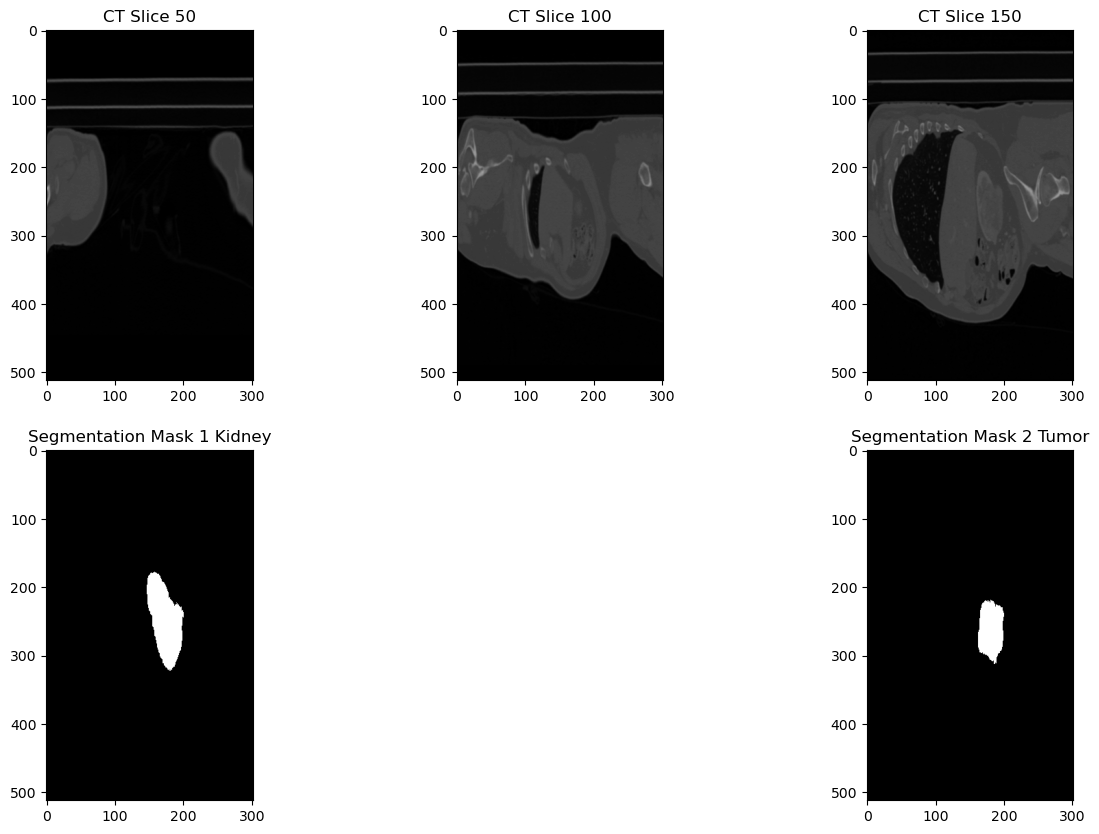

In [114]:
#Defines the file paths for the CT image and segmentation mask
ct_path = "/Users/syn/Downloads/kits21/kits21/data/case_00026/imaging.nii.gz"
segmentation_path1 = "/Users/syn/Downloads/kits21/kits21/data/case_00026/segmentations/kidney_instance-1_annotation-1.nii.gz"
segmentation_path2 = "/Users/syn/Downloads/kits21/kits21/data/case_00026/segmentations/tumor_instance-1_annotation-1.nii.gz"

#Loads the CT image and segmentation mask using nibabel
ct = nib.load(ct_path).get_fdata()
segmentation1 = nib.load(segmentation_path1).get_fdata()
segmentation2 = nib.load(segmentation_path2).get_fdata()

#Sets the color map range to adjust the contrast
vmin_ct = np.min(ct)
vmax_ct = np.max(ct)
vmin_seg = 0
vmax_seg = 1

#Displays multiple slices of the CT image and segmentation mask
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].imshow(np.rot90(ct[:, :, 50]), cmap='gray', vmin=vmin_ct, vmax=vmax_ct)
axs[0, 0].set_title('CT Slice 50')
axs[0, 1].imshow(np.rot90(ct[:, :, 100]), cmap='gray', vmin=vmin_ct, vmax=vmax_ct)
axs[0, 1].set_title('CT Slice 100')
axs[0, 2].imshow(np.rot90(ct[:, :, 150]), cmap='gray', vmin=vmin_ct, vmax=vmax_ct)
axs[0, 2].set_title('CT Slice 150')

axs[1, 0].imshow(np.rot90(np.max(segmentation1, axis=-1)), cmap='gray', vmin=vmin_seg, vmax=vmax_seg)
axs[1, 0].set_title('Segmentation Mask 1 Kidney')
axs[1, 1].axis('off') # remove empty subplot
axs[1, 2].imshow(np.rot90(np.max(segmentation2, axis=-1)), cmap='gray', vmin=vmin_seg, vmax=vmax_seg)
axs[1, 2].set_title('Segmentation Mask 2 Tumor')

plt.show()

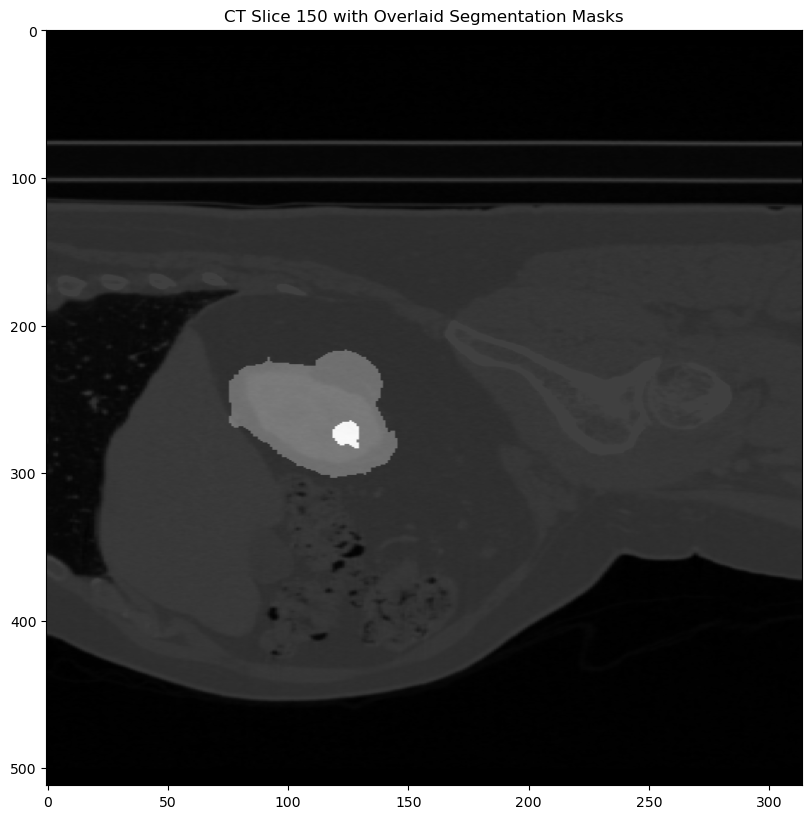

In [115]:
#Defines the file paths for the CT image and segmentation mask
ct_path = "/Users/syn/Downloads/kits21/kits21/data/case_00095/imaging.nii.gz"
segmentation_path1 = "/Users/syn/Downloads/kits21/kits21/data/case_00095/segmentations/kidney_instance-1_annotation-1.nii.gz"
segmentation_path2 = "/Users/syn/Downloads/kits21/kits21/data/case_00095/segmentations/tumor_instance-1_annotation-1.nii.gz"

#Loads the CT image and segmentation mask using nibabel
ct = nib.load(ct_path).get_fdata()
segmentation1 = nib.load(segmentation_path1).get_fdata()
segmentation2 = nib.load(segmentation_path2).get_fdata()

#Sets the color map range to adjust the contrast
#vmin_ct = np.min(ct) #too dark
#vmax_ct = np.max(ct) #too dark
vmin_ct = np.percentile(ct, 1) # set vmin_ct to the 1st percentile of pixel values
vmax_ct = np.percentile(ct, 99) # set vmax_ct to the 99th percentile of pixel values
vmin_seg = 0
vmax_seg = 1

#Noticing that for some cases, the graph is coming out squished so we want to fix that
# Calculate the aspect ratio of the image
height, width, _ = ct.shape
aspect = height / width

#Displays the CT image and segmentation masks overlaid on slice 150
#fig, ax = plt.subplots(figsize=(8, 8)) #old code that outputs squished graph for some cases
fig, ax = plt.subplots(figsize=(16, 16*aspect))

ax.imshow(np.rot90(ct[:, :, 150]), cmap='gray', vmin=vmin_ct, vmax=vmax_ct, aspect=aspect)
ax.imshow(np.rot90(np.max(segmentation1, axis=-1)), cmap='gray', alpha=0.5, vmin=vmin_seg, vmax=vmax_seg, aspect=aspect)
ax.imshow(np.rot90(np.max(segmentation2, axis=-1)), cmap='gray', alpha=0.5, vmin=vmin_seg, vmax=vmax_seg, aspect=aspect)

ax.set_title('CT Slice 150 with Overlaid Segmentation Masks')
plt.show()


We want to start creating the training data from the available data that we have. We noticed that there is a lot of information we dont want to use so we established a workflow to extract the information that we wanted:

1. Define the paths to the data and output directories
2. Define the filenames of the segmentation files we want to extract
3. Loop over all cases in the data directory
4. For each case, load slice 150 of the CT scan as a numpy array
5. Create a subdirectory for each case in the output directory
6. Save the corresponding CT slice image in the output directory
7. For each segmentation file, load the segmentation as a numpy array
8. Create a binary mask for the corresponding kidney instance
9. Save each mask image in the output directory, with a filename indicating the kidney instance number

In [116]:
# import os
# import numpy as np
# import nibabel as nib
# import matplotlib.pyplot as plt
#
# # Here we define the paths to the data and output directories
# data_dir = "/Users/syn/Downloads/kits21/kits21/data"
# output_dir = "/Users/syn/Downloads/kits21/kidney_detection_training_data_preprocessed/"
#
# # Here we define the filenames of the segmentation files we want to extract
# segmentation_filenames = ["kidney_instance-1_annotation-1.nii.gz",
#                           "kidney_instance-1_annotation-2.nii.gz",
#                           "kidney_instance-1_annotation-3.nii.gz",
#                           "kidney_instance-2_annotation-1.nii.gz",
#                           "kidney_instance-2_annotation-2.nii.gz",
#                           "kidney_instance-2_annotation-3.nii.gz"]
#
# # For each case in the data, we want to create a loop to look through them
# for case_dir in os.listdir(data_dir):
#     # Lets make sure we're only looking at directories and not files
#     if os.path.isdir(os.path.join(data_dir, case_dir)):
#         # Here we define the paths to the CT and segmentation files for each case
#         ct_path = os.path.join(data_dir, case_dir, "imaging.nii.gz")
#         segmentation_paths = [os.path.join(data_dir, case_dir, "segmentations", filename) for filename in segmentation_filenames]
#
#         # We want to check if slice 150 of the CT scan and all the annotations exist
#         if not os.path.isfile(ct_path):
#             print(f"Skipping case {case_dir} because CT scan file not found")
#             continue
#
#         for segmentation_path in segmentation_paths:
#             if not os.path.isfile(segmentation_path):
#                 print(f"Skipping case {case_dir} because segmentation file not found: {segmentation_path}")
#                 break
#         else:
#             # Lets load slice 150 of the CT scan as a numpy array
#             ct_slice = nib.load(ct_path).get_fdata()[:, :, 150]
#
#             # Here we define the output directory for each case
#             output_case_dir = os.path.join(output_dir, case_dir)
#             os.makedirs(output_case_dir, exist_ok=True)
#
#             # We want to preprocess the CT slice before saving it into the output directory
#             ct_slice = ct_slice.astype(np.float32)
#             ct_slice -= np.mean(ct_slice)
#             ct_slice /= np.std(ct_slice)
#             ct_slice = np.clip(ct_slice, -3.0, 3.0)
#             ct_slice = (ct_slice + 3.0) / 6.0
#             ct_slice_ext = os.path.splitext(os.path.basename(ct_path))[1].split(".")[1] # extract the file extension from the original file
#             ct_slice_path = os.path.join(output_case_dir, f"ct{ct_slice_ext}")
#             nib.save(nib.Nifti1Image(ct_slice, np.eye(4)), ct_slice_path)
#
#             # We want to loop over each segmentation file and save the corresponding mask
#             for i, segmentation_path in enumerate(segmentation_paths):
#                 segmentation = nib.load(segmentation_path).get_fdata()
#                 mask = (segmentation[:, :, 150] == i+1).astype(np.uint8)
#                 mask_ext = os.path.splitext(os.path.basename(segmentation_path))[1] # extract the file extension from the original file
#                 mask_name = os.path.splitext(os.path.basename(segmentation_path))[0] # extract the segmentation filename without extension
#                 mask_path = os.path.join(output_case_dir, f"{mask_name}{mask_ext}")
#                 nib.save(nib.Nifti1Image(mask, np.eye(4)), mask_path)


In [117]:
!ls /Users/syn/Downloads/kits21/kidney_detection_training_data_preprocessed/case_00001

ctgz.nii                              kidney_instance-2_annotation-1.nii.gz
kidney_instance-1_annotation-1.nii.gz kidney_instance-2_annotation-2.nii.gz
kidney_instance-1_annotation-2.nii.gz kidney_instance-2_annotation-3.nii.gz
kidney_instance-1_annotation-3.nii.gz


In [118]:
DATA_PATH = "/Users/syn/Downloads/kits21/kidney_detection_training_data_preprocessed"

# Loop through all subdirectories in DATA_PATH
for subdir in os.listdir(DATA_PATH):
    subdir_path = os.path.join(DATA_PATH, subdir)
    
    # Loop through all files in the subdirectory
    for file in os.listdir(subdir_path):
        if file.endswith(".png"):
            # If the file ends with .png, delete it
            os.remove(os.path.join(subdir_path, file))


In [119]:
!ls /Users/syn/Downloads/kits21/kidney_detection_training_data_preprocessed/case_00001

ctgz.nii                              kidney_instance-2_annotation-1.nii.gz
kidney_instance-1_annotation-1.nii.gz kidney_instance-2_annotation-2.nii.gz
kidney_instance-1_annotation-2.nii.gz kidney_instance-2_annotation-3.nii.gz
kidney_instance-1_annotation-3.nii.gz


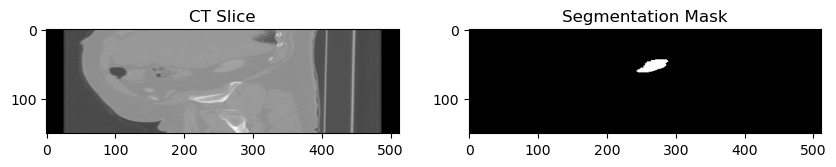

In [163]:
import nibabel as nib
import matplotlib.pyplot as plt

# Set the file paths
ct_file = '/Users/syn/Downloads/kits21/kidney_detection_training_data_preprocessed/case_00081/ctgz.nii'
mask_file = '/Users/syn/Downloads/kits21/kidney_detection_training_data_preprocessed/case_00081/kidney_instance-1_annotation-1.nii.gz'

# Load the CT slice and segmentation mask
ct_nii = nib.load(ct_file)
ct_slice = ct_nii.get_fdata()

mask_nii = nib.load(mask_file)
segmentation_mask = mask_nii.get_fdata()

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the CT slice on the first subplot
axs[0].imshow(ct_slice, cmap='gray')
axs[0].set_title('CT Slice')

# Plot the segmentation mask on the second subplot
axs[1].imshow(segmentation_mask, cmap='gray')
axs[1].set_title('Segmentation Mask')

# Show the figure
plt.show()


In [121]:
import os
import random
import tensorflow as tf

# Set the directory path
TRAIN_DATA_PATH = "/Users/syn/Downloads/kits21/kidney_detection_training_data_preprocessed/"

# Let's create the training, validation and test ids.

train_dir = [f.path for f in os.scandir(TRAIN_DATA_PATH) if f.is_dir()]

# We will create train, validation and test ids from the train_dir dataset


def list_to_ids(dir:str):
    """
    Will convert the dir paths to ids by parsing the paths.
    dir: string, image dir paths in BRATS
    """
    x = []
    for i in range(0,len(dir)):
        x.append(dir[i].split('/')[-1])
    return x

# Now let's use the defined function

ids = list_to_ids(train_dir) 

# Split dataset to create training ids, validation ids and test ids
# Here we have selected the size of test set as 20% which is a common practice.
train_ids, test_ids = train_test_split(ids,test_size=0.2) 

# Create validation ids by further splitting the train ids, we again use 20% as size of valisation set. 
# Validation set is also referred to as tuning set. 

train_ids, val_ids = train_test_split(train_ids,test_size=0.2) 

# Now looks at the number of patient ids in training, validation and test sets
print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(val_ids)} patient ids in validation set')
print(f'There are {len(test_ids)} patient ids in test set')

There are 187 patient ids in training set
There are 47 patient ids in validation set
There are 59 patient ids in test set


In [122]:
print(train_ids)

['case_00212', 'case_00188', 'case_00106', 'case_00153', 'case_00271', 'case_00246', 'case_00170', 'case_00230', 'case_00287', 'case_00009', 'case_00292', 'case_00160', 'case_00040', 'case_00007', 'case_00236', 'case_00289', 'case_00145', 'case_00010', 'case_00174', 'case_00025', 'case_00207', 'case_00096', 'case_00176', 'case_00133', 'case_00027', 'case_00046', 'case_00209', 'case_00189', 'case_00030', 'case_00249', 'case_00259', 'case_00269', 'case_00283', 'case_00118', 'case_00135', 'case_00055', 'case_00124', 'case_00196', 'case_00203', 'case_00275', 'case_00127', 'case_00094', 'case_00279', 'case_00296', 'case_00045', 'case_00204', 'case_00129', 'case_00063', 'case_00250', 'case_00071', 'case_00297', 'case_00079', 'case_00195', 'case_00004', 'case_00086', 'case_00206', 'case_00123', 'case_00134', 'case_00011', 'case_00244', 'case_00076', 'case_00159', 'case_00152', 'case_00156', 'case_00006', 'case_00234', 'case_00227', 'case_00183', 'case_00299', 'case_00264', 'case_00221', 'case

In [123]:
import os
import gzip
import shutil

def read_patient_niftis(patient_id: str, 
                        niftis_to_load = ['ctgz', 'kidney_instance-1_annotation-1', 'kidney_instance-1_annotation-2', 'kidney_instance-1_annotation-3', 'kidney_instance-2_annotation-1', 'kidney_instance-2_annotation-2', 'kidney_instance-2_annotation-3'], 
                        data_path = TRAIN_DATA_PATH):

  patient_image_dict = {}
  for image in niftis_to_load: 
    nii_file = Path(data_path, f'{patient_id}', f'{image}.nii')
    if os.path.isfile(nii_file):
      patient_image_dict[image]=nib.load(nii_file)
    else:
      nii_gz_file = Path(data_path, f'{patient_id}', f'{image}.nii.gz')
      if os.path.isfile(nii_gz_file):
        with gzip.open(nii_gz_file, 'rb') as f_in:
          with open(nii_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
        patient_image_dict[image]=nib.load(nii_file)
      else:
        raise ValueError(f"Neither {nii_file} nor {nii_gz_file} exists.")
        
  return patient_image_dict

In [124]:
pt_img_dict = read_patient_niftis(train_ids[10])
print(pt_img_dict)

{'ctgz': <nibabel.nifti1.Nifti1Image object at 0x7f9024c76320>, 'kidney_instance-1_annotation-1': <nibabel.nifti1.Nifti1Image object at 0x7f9024c76fe0>, 'kidney_instance-1_annotation-2': <nibabel.nifti1.Nifti1Image object at 0x7f9024c76bf0>, 'kidney_instance-1_annotation-3': <nibabel.nifti1.Nifti1Image object at 0x7f9024c76650>, 'kidney_instance-2_annotation-1': <nibabel.nifti1.Nifti1Image object at 0x7f9024c76ec0>, 'kidney_instance-2_annotation-2': <nibabel.nifti1.Nifti1Image object at 0x7f9024c76830>, 'kidney_instance-2_annotation-3': <nibabel.nifti1.Nifti1Image object at 0x7f9024c76860>}


In [125]:
from tensorflow.keras.layers import UpSampling2D

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

def dice_coef(y_true, y_pred, smooth=1):
    y_true = K.expand_dims(y_true, axis=-1)
    y_pred = K.expand_dims(y_pred, axis=-1)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true[..., 0], y_pred[..., 0])

In [126]:
from tensorflow.keras.layers import Resizing


# Define the UNet model
def get_unet(input_shape=(None, None, 1),
                  num_classes=1,
                  resize_shape=None):
    inputs = Input(shape=input_shape)
    if resize_shape is not None:
        resized = Resizing(resize_shape[0], resize_shape[1])(inputs)
        down1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(resized)
    else:
        down1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)


    down2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)


    down3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
 

    down4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)


    center = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(center)
    center = BatchNormalization()(center)


    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)


    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
 

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)


    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=Adam(learning_rate=0.00005), loss=dice_coef_loss, metrics=[dice_coef])
    return model

model = get_unet()

In [139]:
from typing import List
import os
import numpy as np
import nibabel as nib
from skimage.transform import resize

def read_patient_niftis(patient_id: str, niftis_to_load: List[str], data_path: str) -> dict:
    pt_img_dict = {}

    for nifti_type in niftis_to_load:
        nifti_file_gz = os.path.join(data_path, patient_id, f"{nifti_type}.nii.gz")
        nifti_file = os.path.join(data_path, patient_id, f"{nifti_type}.nii")
        
        if os.path.exists(nifti_file_gz):
            img = nib.load(nifti_file_gz)
            pt_img_dict[nifti_type] = (img.get_fdata(), img.shape)
        elif os.path.exists(nifti_file):
            img = nib.load(nifti_file)
            pt_img_dict[nifti_type] = (img.get_fdata(), img.shape)
        else:
            print(f"File not found: {nifti_file_gz} or {nifti_file}")

    return pt_img_dict


def create_numpy_array(patient_ids: List[str], DATA_PATH: str) -> tuple:
    X = []
    Y = []

    niftis_to_load = [
        'ctgz', 
        'kidney_instance-1_annotation-1']
    target_shape = (256, 256)

    for i in range(len(patient_ids)):
        pt_img_dict = read_patient_niftis(patient_ids[i], niftis_to_load, DATA_PATH)

        # Check if all Nifti files were loaded successfully
        if len(pt_img_dict) < len(niftis_to_load):
            print(f"Skipping patient {patient_ids[i]} due to missing Nifti files")
            continue

        images = []
        for key, (data, shape) in pt_img_dict.items():
            if shape[1] >= 256:  # Add a check to make sure the second dimension is at least 256
                # Resize data to the target shape
                data_resized = resize(data, target_shape, anti_aliasing=True)
                images.append(data_resized)

        # Check if images list is not empty before trying to concatenate
        if len(images) == 0:
            print(f"Skipping patient {patient_ids[i]} due to empty images list")
            continue

        # Resize all images to the same shape
        max_shape = max([img.shape for img in images])
        images_resized = []
        for img in images:
            pad_width = [(0, max_shape[i] - img.shape[i]) for i in range(len(max_shape))]
            img_padded = np.pad(img, pad_width=pad_width, mode='constant', constant_values=0)
            images_resized.append(img_padded)

        X.append(np.stack(images_resized[0], axis=1))
        Y.append(np.stack(images_resized[1], axis=1))

    return np.asarray(X), np.asarray(Y)


X_train, Y_train = create_numpy_array(train_ids, TRAIN_DATA_PATH)
X_val, Y_val = create_numpy_array(val_ids, TRAIN_DATA_PATH)
X_test, Y_test = create_numpy_array(test_ids, TRAIN_DATA_PATH)

In [140]:
# Let's confirm the size of the training, validation and test arrays.
print(f'There are {len(X_train)} images in training set')
print(f'There are {len(X_val)} images in validation set')
print(f'There are {len(X_test)} images in test set')

There are 187 images in training set
There are 47 images in validation set
There are 59 images in test set


In [141]:
# Lets create tensor datasets from numpy arrays
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset_train = dataset_train.map(lambda x, y: {'image': x, 'segmentation_mask': y})
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
dataset_val = dataset_val.map(lambda x, y: {'image': x, 'segmentation_mask': y})
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
dataset_test = dataset_test.map(lambda x, y: {'image': x, 'segmentation_mask': y})

In [142]:
# Let's create image loader to resize the image
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_masks = []
    for mask_key in datapoint.keys():
        if 'mask' in mask_key:
            input_mask = tf.image.resize(datapoint[mask_key], (128, 128))
            input_masks.append(input_mask)
    input_mask = tf.stack(input_masks, axis=-1)
    return input_image, input_mask

In [143]:
TRAIN_LENGTH = len(train_ids)
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = 5

In [144]:
train_batches = (
    dataset_train
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = dataset_val.batch(BATCH_SIZE)
test_batches = dataset_test.batch(BATCH_SIZE)

In [159]:
# Let's write a function to show the predictions
dataset = dataset_train
num = 2

if dataset:
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], pred_mask[0]])
else:
    display([sample_image, sample_mask, model.predict(sample_image[tf.newaxis, ...])])

IndexError: tuple index out of range

In [150]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Lambda, UpSampling2D

smooth = 1.
EPOCHS = 5   
VAL_SUBSPLITS = 5
VALIDATION_STEPS = len(val_ids)//BATCH_SIZE//VAL_SUBSPLITS
optimizer = Adam(learning_rate=0.00005)

model.compile(optimizer=optimizer, loss=dice_coef_loss, metrics=[dice_coef])


model_history = model.fit(train_batches.map(lambda x: (x['image'], x['segmentation_mask'])), epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=val_batches.map(lambda x: (x['image'], x['segmentation_mask'])),
                          validation_steps=VALIDATION_STEPS)

Epoch 1/5
5/5 [==============================] - 47s 9s/step - loss: -0.0251 - dice_coef: 0.0425 - val_loss: -0.0019 - val_dice_coef: 0.0563
Epoch 2/5
5/5 [==============================] - 46s 9s/step - loss: -0.6009 - dice_coef: 0.0651 - val_loss: -0.0019 - val_dice_coef: 0.0565
Epoch 3/5
5/5 [==============================] - 46s 9s/step - loss: -0.9915 - dice_coef: 0.0572 - val_loss: -0.0019 - val_dice_coef: 0.0564
Epoch 4/5
5/5 [==============================] - 126s 9s/step - loss: -0.9997 - dice_coef: 0.0493 - val_loss: -0.0019 - val_dice_coef: 0.0563
Epoch 5/5
5/5 [==============================] - 46s 9s/step - loss: -0.9999 - dice_coef: 0.0505 - val_loss: -0.0019 - val_dice_coef: 0.0563


In [151]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


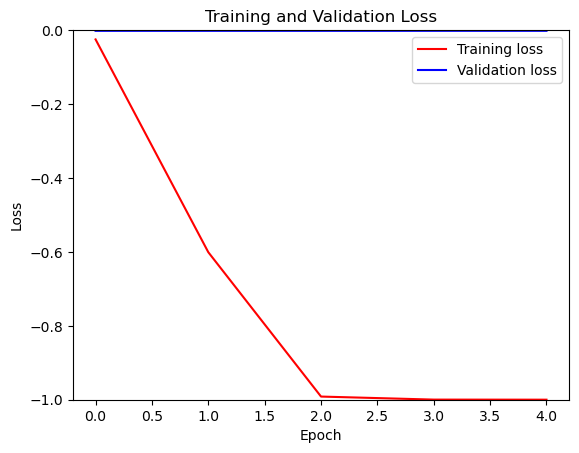

In [152]:
# Let's take a look at the learning curve now
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([-1, 0])
plt.legend()
plt.show()